In [1]:
import numpy as np

## The normal equations

In [2]:
# least squares problem with known solution
A = np.random.randn(100,4)
x = np.array([1,1,1,0])
b = A.dot(x)
# column 3 is almost a combination of columns 0 and 1
A[:,3] = A[:,0]-A[:,1] + 1e-10*np.random.randn(100)

In [3]:
# solving the normal equations
xNormal = np.linalg.solve(A.T.dot(A), A.T.dot(b))
xNumpy = np.linalg.lstsq(A,b,rcond=None)[0]

In [4]:
xNumpy

array([ 1.00000037e+00,  9.99999633e-01,  1.00000000e+00, -3.66687474e-07])

In [5]:
xNormal

array([ 4.43748986, -2.43748986,  1.        , -3.43748986])

In [6]:
np.linalg.cond(A) # approx 10^-10

28968279577.917976

In [7]:
np.linalg.cond(A.T.dot(A))

1.1613404891886218e+16

## QR by using Gram-Schmidt

In [8]:
def my_qr(A):
    'it factors a full-column rank A into Q (orthogonal) times R (upper triangular)'
    m,n = A.shape
    
    Q = A.copy()
    R = np.zeros((n,n))
    
    for i in range(n):
        R[0:i,i] = Q[:,0:i].T.dot(Q[:,i])
        Q[:,i] = Q[:,i] - Q[:,0:i].dot(R[0:i,i])
        R[i,i] = np.linalg.norm(Q[:,i])
        Q[:,i] = Q[:,i]/R[i,i]
    return Q,R

In [9]:
A = np.random.randn(10,5)
Q,R=my_qr(A)

In [10]:
# check that A = QR
np.linalg.norm(A-Q.dot(R))

3.0960318988224324e-16

In [11]:
# check that columns of Q are orthonormal
np.linalg.norm(Q.T.dot(Q)-np.eye(5))

5.043482897809253e-16

In [12]:
# check that R is upper triangular and invertible
R

array([[ 2.10607461,  1.55079288,  0.72804912,  2.64466899, -0.16499803],
       [ 0.        ,  3.53070472,  0.32657601, -0.47090524,  0.23408253],
       [ 0.        ,  0.        ,  2.56522289, -0.03725312,  0.2903819 ],
       [ 0.        ,  0.        ,  0.        ,  2.62269243, -1.23532858],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  2.08882062]])

### Timing Gram-Schmidt

In [13]:
import time

In [14]:
import matplotlib.pyplot as plt

In [15]:
# matrix sizes
ns = [250,500,1000,2000]

In [16]:
t = np.zeros(len(ns))
for i,n in enumerate(ns): # loop over matrix sizes
    print(n)
    A = np.random.randn(n,n) # random nxn matrix
    start = time.time() # start clock
    _,_=my_qr(A) # QR factorization of A
    end = time.time() # stop clock
    t[i] = end - start # store elapsed time

250
500
1000
2000


Text(0, 0.5, 'time')

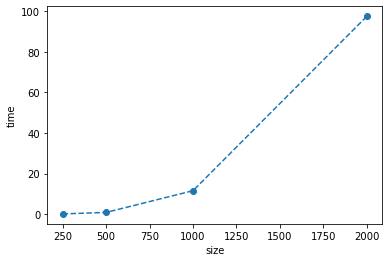

In [17]:
plt.plot(ns,t,'o--')
plt.xlabel('size')
plt.ylabel('time')

Text(0, 0.5, 'time')

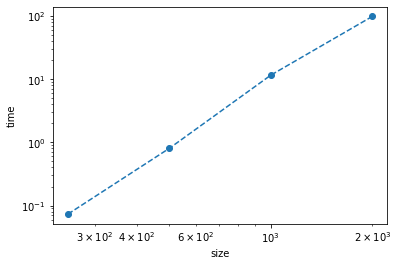

In [18]:
plt.loglog(ns,t,'o--')
plt.xlabel('size')
plt.ylabel('time')

In [19]:
# slope
(np.log(t[3])-np.log(t[0]))/(np.log(ns[3])-np.log(ns[0]))

3.4597948911465326

### Gram-Schmidt and rounding errors

In [20]:
# vandermonde matrix 
n = 15
m = 20
p = np.arange(1,m+1)/m
A = np.vander(p,N=n,increasing=True)

In [21]:
# deviation from orthonormality
Q,R = my_qr(A)
np.linalg.norm(np.eye(n) - Q.T.dot(Q)) 

5.459539405674028

In [22]:
# initialize deviation from orthonormality vector
k = 10
dev_orth_gram = []
dev_orth_scipy = []
for i in range(k):
    n = 4 + 2*i 
    m = 6 + 3*i 
    # build Vandermonde matrix
    p = np.arange(1,m+1)/m
    A = np.vander(p,N=n,increasing=True)
    # Gram-Schmidt
    Q,R = my_qr(A)
    dev_orth_gram.append(np.linalg.norm(np.eye(n) - Q.T.dot(Q)))
    
    # scipy built-in function 
    Q,R = np.linalg.qr(A)
    dev_orth_scipy.append(np.linalg.norm(np.eye(n) - Q.T.dot(Q)))

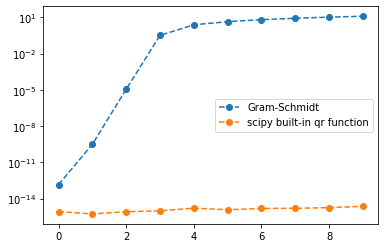

In [23]:
plt.semilogy(dev_orth_gram,'o--', label='Gram-Schmidt')
plt.semilogy(dev_orth_scipy,'o--', label='scipy built-in qr function')
plt.legend()

### Reflectors

In [24]:
n = 5
x = 10*np.random.randn(n)
x

array([ 2.84433647,  4.142868  ,  3.44596202, -3.48937279, -7.88408893])

In [25]:
u = x.copy()
tau = np.sign(u[0])*np.linalg.norm(u)
u[0] = tau + u[0]
gamma = u[0]/tau
u[1:n] = u[1:n]/u[0]
u[0] = 1
tau = tau

In [26]:
x - gamma*u*(u.dot(x))

array([-1.05575963e+01, -8.88178420e-16, -4.44089210e-16,  1.33226763e-15,
        1.77635684e-15])

In [27]:
def my_qr(A,how='reflectors',mode='economic'):
    'it factors a full-column rank A into Q (orthogonal) times R (upper triangular)'
    m,n = A.shape
    
    if how=='Gram-Schmidt':
        Q = A.copy()
        R = np.zeros((n,n))

        for i in range(n):
            R[0:i,i] = Q[:,0:i].T.dot(Q[:,i])
            Q[:,i] = Q[:,i] - Q[:,0:i].dot(R[0:i,i])
            R[i,i] = np.linalg.norm(Q[:,i])
            Q[:,i] = Q[:,i]/R[i,i]
        return Q,R
    elif how=='reflectors':
        R = A.copy()
        Q = np.eye(m)

        for j in range(n):

            # create reflector
            x = R[j:m,j].copy()
            tau = np.sign(x[0])*np.linalg.norm(x)
            x[0] = tau + x[0]
            gamma = x[0]/tau
            x[1:len(x)] = x[1:len(x)]/x[0]
            x[0] = 1
            tau = tau

            # apply reflector to R
            R[j:m,j:n] = R[j:m,j:n] - gamma*np.outer(x,x.dot(R[j:m,j:n]))
            # apply reflector to P
            Q[j:m,:] = Q[j:m,:] - gamma*np.outer(x,x.dot(Q[j:m,:]))

        if mode == 'complete':
            return Q.T, np.triu(R)
        if mode == 'economic':
            return Q.T[:,0:n], np.triu(R)[0:n]

In [28]:
A = np.random.randn(10,4)

In [29]:
Q,R=my_qr(A) # how='reflectors'; mode='economic'

In [30]:
# check R is upper triangular
R

array([[ 2.40444963,  1.13999439,  0.71841657,  0.60245191],
       [ 0.        ,  2.64812645,  0.72729914, -0.30743875],
       [ 0.        ,  0.        ,  2.06128869, -0.48128042],
       [ 0.        ,  0.        ,  0.        , -3.16482037]])

In [31]:
# check columns of Q are orthonormal
np.linalg.norm(Q.T.dot(Q)-np.eye(4))

7.006736879237091e-16

In [32]:
# check A = QR
np.linalg.norm(A-Q.dot(R))

1.904407211319106e-15

In [33]:
# deviation from orthonormality 
k = 10
dev_orth_gram = []
dev_orth_reflectors = []
dev_orth_scipy = []
for i in range(k):
    n = 4 + 2*i 
    m = 6 + 3*i 
    # build Vandermonde matrix
    p = np.arange(1,m+1)/m
    A = np.vander(p,N=n,increasing=True)
    # Gram-Schmidt
    Q,R = my_qr(A,how='Gram-Schmidt')
    dev_orth_gram.append(np.linalg.norm(np.eye(n) - Q.T.dot(Q)))
    
    # scipy built-in function 
    Q,R = np.linalg.qr(A)
    dev_orth_scipy.append(np.linalg.norm(np.eye(n) - Q.T.dot(Q)))

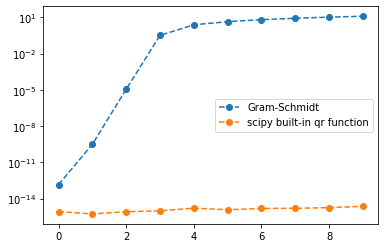

In [34]:
plt.semilogy(dev_orth_gram,'o--', label='Gram-Schmidt')
plt.semilogy(dev_orth_scipy,'o--', label='scipy built-in qr function')
plt.legend()

In [35]:
# least squares problem with known solution
A = np.random.randn(100,4)
x = np.array([1,1,1,0])
b = A.dot(x)
# column 3 is almost a combination of columns 0 and 1
A[:,3] = A[:,0]-A[:,1] + 1e-10*np.random.randn(100)

In [36]:
# we'll solve the least squares problem four different ways:

# normal equations
xNormal = np.linalg.solve(A.T.dot(A), A.T.dot(b))

# NumPy built-in function
xNumpy = np.linalg.lstsq(A,b,rcond=None)[0]

# QR by Gram-Schmidt
Q,R = my_qr(A,how='Gram-Schmidt')
xGM = np.linalg.solve(R,Q.T.dot(b))

# QR by reflectors
Q,R = my_qr(A,how='reflectors',mode='economic')
xReflectors = np.linalg.solve(R,Q.T.dot(b))

In [37]:
xNormal

array([-3.50000106,  5.50000106,  1.        ,  4.50000106])

In [38]:
xGM

array([ 1.86955056e+04, -1.86935056e+04,  9.99999885e-01, -1.86945056e+04])

In [39]:
xNumpy

array([9.99999355e-01, 1.00000064e+00, 1.00000000e+00, 6.44628168e-07])

In [40]:
xReflectors

array([9.99998482e-01, 1.00000152e+00, 1.00000000e+00, 1.51803534e-06])

## Fitting lines/polynomials to data

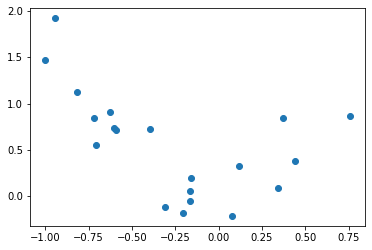

In [41]:
m = 20
np.random.seed(1)
t = -1 + 2*np.random.rand(m)

np.random.seed(2)
y = 2*t**2 + 0.25*np.random.randn(m)

plt.scatter(t,y)

In [42]:
deg = 18
A = np.zeros((m,deg+1))
for i in range(deg+1):
    A[:,i] = t**i
theta = np.linalg.lstsq(A,y,rcond=None)[0]

In [43]:
m_plot = 100
t_plot = np.linspace(-1,1,m_plot)
A_plot = np.zeros((m_plot,deg+1))
for i in range(deg+1):
    A_plot[:,i] = t_plot**i
y_plot = A_plot.dot(theta)

(-5.0, 5.0)

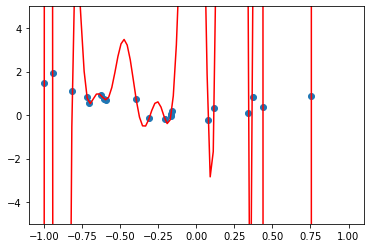

In [44]:
plt.scatter(t,y)
plt.plot(t_plot,y_plot,color='red')
plt.ylim([-5,5])

In [45]:
np.linalg.cond(A)

337243181988.3641

In [46]:
U,S,V=np.linalg.svd(A)

In [47]:
# S contains the singular values
S

array([5.97883072e+00, 3.61167511e+00, 1.84935272e+00, 9.24891314e-01,
       4.44839598e-01, 2.22250292e-01, 7.23692073e-02, 2.75702600e-02,
       7.77606602e-03, 2.67162414e-03, 7.70375775e-04, 1.01791905e-04,
       2.74817695e-05, 5.53840657e-06, 1.48958634e-06, 1.39496188e-07,
       1.20413162e-08, 1.72903910e-10, 1.77285444e-11])

In [48]:
# condition number
S[0]/S[-1]

337243181988.3643

In [49]:
# plot singular values

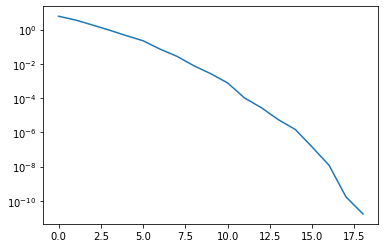

In [50]:
# plot singular values
plt.semilogy(S)

## least squares by SVD

In [51]:
A.shape

(20, 19)

In [52]:
U,S,VT = np.linalg.svd(A,full_matrices=False)

In [53]:
U.shape, VT.shape

((20, 19), (19, 19))

In [54]:
theta = VT.T.dot((U.T.dot(y))/S)

In [55]:
theta

array([ 2.41722336e+01, -1.28246602e+02, -3.95636539e+03,  2.05279947e+03,
        2.10024148e+05,  5.60298468e+05, -2.56159140e+06, -1.22371747e+07,
        2.56033899e+06,  8.64785297e+07,  1.05760073e+08, -1.90901627e+08,
       -5.10262528e+08, -1.46664044e+08,  5.82785715e+08,  5.97207537e+08,
        2.99666585e+07, -1.99724054e+08, -7.37333756e+07])

In [56]:
len(theta)

19

In [57]:
m_plot = 100
t_plot = np.linspace(-1,1,m_plot)
A_plot = np.zeros((m_plot,deg+1))
for i in range(deg+1):
    A_plot[:,i] = t_plot**i
y_plot = A_plot.dot(theta)



(-5.0, 5.0)

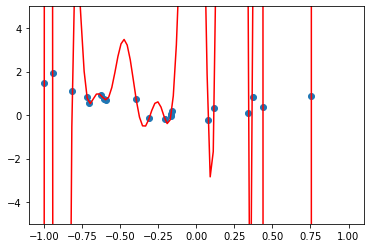

In [58]:
plt.scatter(t,y)
plt.plot(t_plot,y_plot,color='red')
plt.ylim([-5,5])

## Truncated SVD

In [59]:
# largest sing. value
S[0]

5.978830723617371

In [115]:
# threshold
threshold = S[0]*0.0005
k = np.argwhere(S<threshold)[0]-1
k = k[0]
k

8

In [116]:
Uk = U[:,0:k]
VkT = VT[0:k,:]
Sk = S[0:k]

In [117]:
theta = VkT.T.dot((Uk.T.dot(y))/Sk)

In [118]:
theta

array([-0.0339642 ,  0.61287424,  3.60382183, -4.23123897, -4.19625414,
        5.70974866, -2.14779099,  2.20305325,  2.03540189, -1.90581776,
        4.25082437, -3.44762188,  3.9688847 , -2.50689426,  1.76261369,
        0.15477841, -1.65931126,  3.82371828, -5.72729982])

In [119]:
len(theta)

19

In [120]:
m_plot = 100
t_plot = np.linspace(-1,1,m_plot)
A_plot = np.zeros((m_plot,deg+1))
for i in range(deg+1):
    A_plot[:,i] = t_plot**i
y_plot = A_plot.dot(theta)


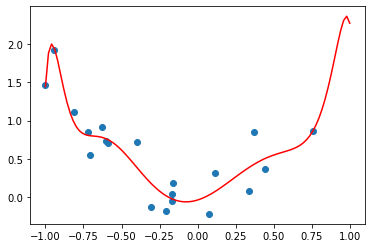

In [121]:
plt.scatter(t,y)
plt.plot(t_plot,y_plot,color='red')
#plt.ylim([-5,5])

## Regularized SVD

In [100]:
A = np.arange(0,6).reshape(2,3)
B = np.arange(0,9).reshape(3,3)
np.vstack((A,B))

array([[0, 1, 2],
       [3, 4, 5],
       [0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])